In [17]:
import os
import numpy as np
import pandas as pd
import torch
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader

In [18]:
### THIS CELL MAKES YOU SIGN IN ON GOOGLE AND TRUST THIS JUPYTER FILE.

from google.colab import drive
drive.mount('/content/drive')

data_dir = '/content/drive/My Drive/ECE 4715/ML_Project/data'

print(data_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/ECE 4715/ML_Project/data


In [19]:
# Set paths for train and test data
# data_dir = "./data"  # Using data dir from google drive, assuming the ML_Project
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")


data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
    ]),
}


In [20]:
def extract_features(data_dir, model, transform):
    # Create the dataset with the appropriate transform
    dataset = datasets.ImageFolder(data_dir, transform=transform)
    dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

    features = []
    labels = []

    model.eval()
    with torch.no_grad():
        for inputs, targets in tqdm(dataloader):
            inputs = inputs.to(device)
            outputs = model(inputs).cpu().numpy()  # Extract features
            features.append(outputs)
            labels.append(targets.numpy())

    features = np.vstack(features)
    labels = np.hstack(labels)
    return features, labels, dataset.classes

In [21]:
# Load a pre-trained ResNet model for feature extraction
feature_extractor = models.resnet101(weights=models.ResNet101_Weights.IMAGENET1K_V2)
for param in feature_extractor.parameters():
    param.requires_grad = False

# Remove the final classification layer
feature_extractor.fc = torch.nn.Identity()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
feature_extractor = feature_extractor.to(device)

# Extract features for train and test sets
train_features, train_labels, class_names = extract_features(train_dir, feature_extractor, data_transforms['train'])
test_features, test_labels, _ = extract_features(test_dir, feature_extractor, data_transforms['test'])

# Train a Random Forest classifier
print("Training Random Forest Classifier...")
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(train_features, train_labels)

100%|██████████| 13/13 [00:58<00:00,  4.51s/it]


Training Random Forest Classifier...


RandomForestClassifier(random_state=42)

In [22]:
# Define the learning rate scheduler
##scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.1)

In [23]:
# Evaluate the model
train_preds = rf_classifier.predict(train_features)
test_preds = rf_classifier.predict(test_features)

train_accuracy = accuracy_score(train_labels, train_preds) * 100
test_accuracy = accuracy_score(test_labels, test_preds) * 100

print(f"Training Accuracy: {train_accuracy:.2f}%")
print(f"Testing Accuracy: {test_accuracy:.2f}%")

Training Accuracy: 99.88%
Testing Accuracy: 56.28%


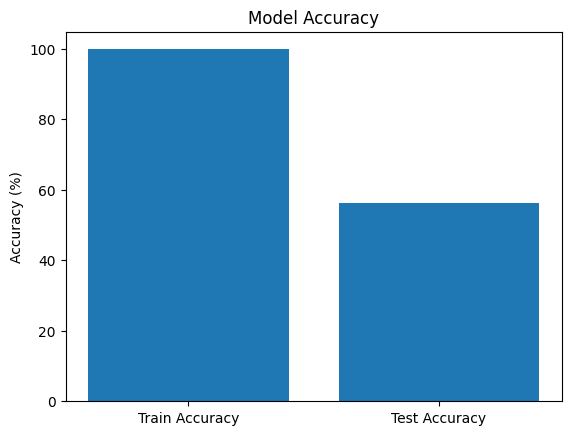

In [25]:
# Assuming you have calculated training and testing accuracy
train_accuracy = accuracy_score(train_labels, rf_classifier.predict(train_features))
test_accuracy = accuracy_score(test_labels, rf_classifier.predict(test_features))

# Plot accuracy comparison
plt.bar(['Train Accuracy', 'Test Accuracy'], [train_accuracy * 100, test_accuracy * 100])
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy')
plt.show()


In [29]:
# Display confusion matrices
def display_confusion_matrix(true_labels, predicted_labels, is_train=False):
    cm = confusion_matrix(true_labels, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', xticks_rotation=45, colorbar=False)
    plt.title("Training Confusion Matrix" if is_train else "Testing Confusion Matrix")
    plt.show()

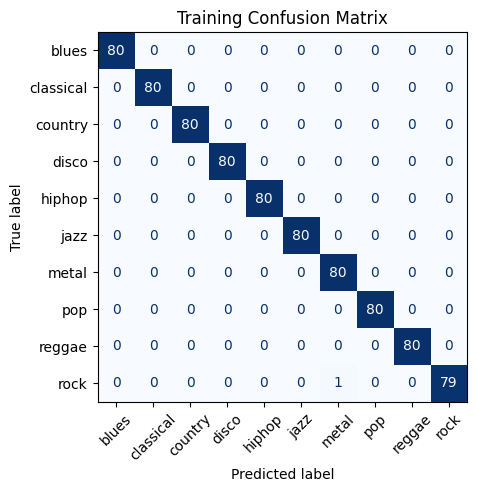

In [30]:
display_confusion_matrix(train_labels, train_preds, is_train=True)

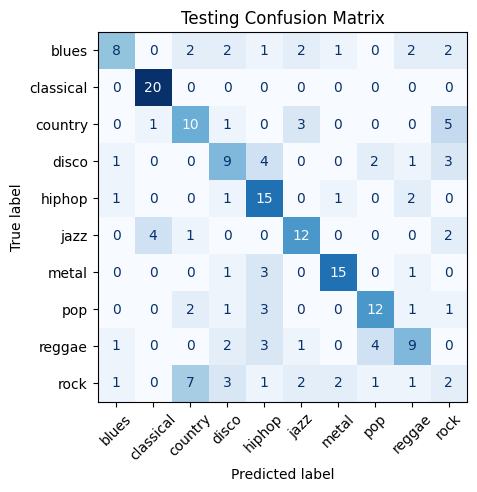

In [31]:
display_confusion_matrix(test_labels, test_preds, is_train=False)

In [ ]:
# Plot feature importance
feature_importances = rf_classifier.feature_importances_
plt.bar(range(len(feature_importances)), feature_importances)
plt.title("Feature Importance")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.show()